<a href="https://colab.research.google.com/github/carboni123/pytorchObjectDetection_refs/blob/main/COLAB-example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cython
!pip install pycocotools

In [2]:
!git clone https://github.com/carboni123/pytorchObjectDetection_refs

Cloning into 'pytorchObjectDetection_refs'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 0), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [3]:
!mv pytorchObjectDetection_refs detection

# Dataset

In [4]:
%cd /content/

/content


In [5]:
!curl -L "https://app.roboflow.com/ds/OEoAOtl7F4?key=O28n4fkdaj" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
!mkdir dataset
!mv ./train/ ./dataset/
!mv ./valid/ ./dataset/
!mv ./test/ ./dataset/


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1416      0 --:--:-- --:--:-- --:--:--  1414
100 6435k  100 6435k    0     0  7239k      0 --:--:-- --:--:-- --:--:-- 7239k
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/000008_jpg.rf.xePUN9B6aXE8BpSeKKMX.jpg  
 extracting: test/000011_jpg.rf.Vb8JNGaQ1ShRPREBBO5d.jpg  
 extracting: test/000034_jpg.rf.hKLOcOBlfiErJnysqEDf.jpg  
 extracting: test/000047_jpg.rf.YLrBBrqTHznbVRif2zQP.jpg  
 extracting: test/000054_jpg.rf.qZfvVXN4sh2GmdeW9lhR.jpg  
 extracting: test/000073_jpg.rf.ZmXc0ij9gXoY21YSKosL.jpg  
 extracting: test/000076_jpg.rf.ShINkpacwkiNUoaVJtbm.jpg  
 extracting: test/000084_jpg.rf.zVL6qaXD6fkYJHjwFmyk.jpg  
 extracting: test/000097_jpg.rf.pQq34JMWymv7ETcrLEmi.jpg  
 extracting: test/000098_jpg.rf.59Spat94qsxSmhGLdNuq.jpg  
 extracting: t

In [6]:
!mkdir dataset/annotations
!cp dataset/train/_annotations.coco.json dataset/annotations/train.json
!cp dataset/valid/_annotations.coco.json dataset/annotations/valid.json
!cp dataset/test/_annotations.coco.json dataset/annotations/test.json

#Train

In [7]:
%cd /content/detection

/content/detection


In [11]:
!python -m torch.distributed.launch --nproc_per_node=1 --use_env train.py\
    --dataset custom --model fasterrcnn_resnet50_fpn  --epochs 26\
    --lr-steps 16 22 --aspect-ratio-group-factor 3 --data-path=/content/dataset

| distributed init (rank 0): env://
Namespace(aspect_ratio_group_factor=3, batch_size=2, data_path='/content/dataset', dataset='custom', device='cuda', dist_backend='nccl', dist_url='env://', distributed=True, epochs=26, gpu=0, lr=0.02, lr_gamma=0.1, lr_step_size=8, lr_steps=[16, 22], model='fasterrcnn_resnet50_fpn', momentum=0.9, output_dir='.', pretrained=False, print_freq=20, rank=0, resume='', rpn_score_thresh=None, start_epoch=0, test_only=False, trainable_backbone_layers=None, weight_decay=0.0001, workers=4, world_size=1)
Loading data
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Creating data loaders
Using [0, 0.5, 0.6299605249474366, 0.7937005259840997, 1.0, 1.2599210498948732, 1.5874010519681994, 2.0, inf] as bins for aspect ratio quantization
Count of instances per bin: [210]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarn

#Testing

In [13]:
#Generated model
PATH= '/content/detection/model_25.pth'

In [15]:
#load model
import torch
import torchvision
import torchvision.models.detection

device = torch.device("cuda")
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=4, pretrained=False)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [16]:
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [22]:
from PIL import Image
from torchvision import transforms, models
import matplotlib.pyplot as plt

def load_img(dirpath, imgpath, shape= None):
    image= Image.open(os.path.join(dirpath,imgpath)).convert("RGB")
    plt.imshow(image)

    transform= transforms.Compose([
                             transforms.ToTensor(),
                             ])
    image= transform(image)
    return image

In [23]:
import os
testdir= '/content/dataset/test'
testimgs= os.listdir(testdir)



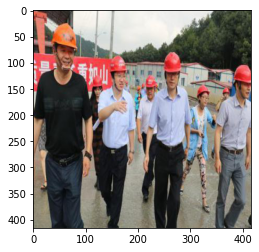

In [24]:
from PIL import Image
# pick one image from the test set
img= load_img(testdir, testimgs[2])

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [25]:
prediction

[{'boxes': tensor([[207.8896, 119.1553, 242.0762, 172.7764],
          [242.8256,  73.3543, 287.0423, 156.2727],
          [378.8009,  98.9547, 416.0000, 175.3701],
          [306.4630, 137.3602, 340.9088, 189.5054],
          [ 27.4378,  14.1236,  91.3686, 131.1628],
          [141.2783,  81.4966, 185.0626, 156.9761],
          [358.1377, 145.1209, 377.9760, 173.1932],
          [107.8013, 119.9415, 137.9855, 171.3751],
          [195.8759, 140.4580, 208.7844, 165.3464],
          [408.8020,  96.0158, 413.6144, 176.6720]], device='cuda:0'),
  'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0'),
  'scores': tensor([0.9998, 0.9997, 0.9996, 0.9996, 0.9994, 0.9991, 0.9985, 0.9895, 0.3372,
          0.0571], device='cuda:0')}]

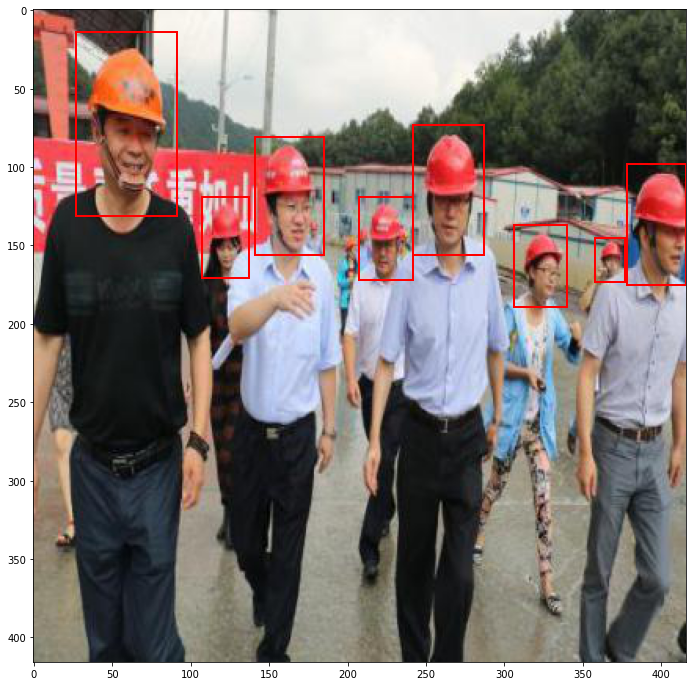

In [26]:
from PIL import ImageOps
import numpy as np
image= (np.array(img.mul(255).permute(1, 2, 0)).astype('uint8'))

plt.figure(figsize=(15,12))  
plt.imshow(image)



from matplotlib.patches import Rectangle
ax = plt.gca()

boxes= prediction[0]['boxes']
j=0
for bbox in boxes:
  xmin, ymin, xmax, ymax = [int(i) for i in bbox.cpu().numpy()]
  if prediction[0]['scores'][j] >0.5:
    rect = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    j+=1
  else: continue